In [1]:
# meassurement of the accuracy 

#accuracy is mean{ p in dotplot @ i,j  |  i,j in real_structure }

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
import sys
sys.path.insert(0,'..')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')

# Load data

In [3]:
import rna_tools.rna_io as rio

def getdata():
    return rio.get_all_data("../data/RNA16.react","../data/RNA16.dbn")  # {key: rea, seq, stru}

data = getdata()

for k,v in data.items():print k,"\t",  len(v[1])

ADDRSW 	121
GLYCFN 	205
tRNAphe 	76
RNAsep 	154
ZHCV 	95
Z-CIDGMP-1 	135
adenin 	71
tRNA-asp 	75
23sRNA 	2904
p564 	155
srRNA 	120
ZGLY 	198
MDLOOP 	80
R009 	1542
5srRNA 	170
TRP5 	202


# train predict

In [4]:
import simushape as sim
from rna_tools.rnaplfold import rnaplfold

data = getdata()
model  = sim.make_model(data,['23sRNA','R009'])
data.pop("23sRNA")
data.pop("R009")
keys = data.keys()[:20]

def get_str(seq):
    for _, data_seq, db in data.values():
        if seq == data_seq:
            return [db]
    print "SHIT"

# acc_calculator needs seq struct rea
predictions = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1], seq_to_db_function=get_str)) for k in keys  }



# get accuracy

In [5]:
from rna_tools.sukosd import sukosd
from rna_tools.rna_accuracy import get_structure_accuracy

acc_shaker = {k: get_structure_accuracy(*predictions[k])  for  k in keys} 


predictions_suko = { k: (data[k][1],data[k][2],sukosd(data[k][2])) for k in keys }

acc_suko = {k: get_structure_accuracy(*predictions_suko[k])  for  k in keys} 

acc_real = {k: get_structure_accuracy(data[k][1],data[k][2],data[k][0])  for  k in keys}


acc_noshape = {k: get_structure_accuracy(data[k][1],data[k][2],None)  for  k in keys}




../rna_tools/rnaplfold.py:31: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if react == None:


# Visualize 

                suko    shaker      real  no_shape
ADDRSW      0.993844  0.992601  0.987444  0.872423
GLYCFN      0.870842  0.957059  0.000000  0.565605
tRNAphe     0.647425  0.993299  0.995362  0.504352
RNAsep      0.718921  0.690159  0.676623  0.530544
ZHCV        0.853871  0.896065  0.533042  0.744884
Z-CIDGMP-1  0.736053  0.844408  0.759976  0.727020
adenin      0.942925  0.988006  0.981553  0.871697
tRNA-asp    0.942070  0.805720  0.550157  0.518002
p564        0.718394  0.906855  0.904553  0.625162
srRNA       0.750333  0.892955  0.849606  0.274786
ZGLY        0.973732  0.958706  0.862487  0.482860
MDLOOP      0.998663  0.998248  0.991718  0.988975
5srRNA      0.935057  0.965159  0.252744  0.260634
TRP5        0.884912  0.903555  0.821419  0.838098
mean        0.854789  0.913771  0.726192  0.628932


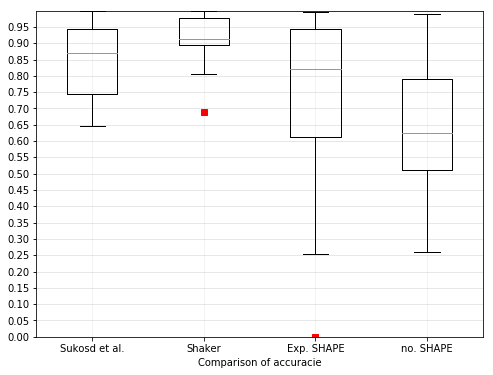

In [46]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
index= ['suko',"shaker",'real',"no_shape"]
data = map(lambda x: [x[k] for k in keys] ,[acc_suko, acc_shaker, acc_real, acc_noshape])
map(lambda x:x.append(np.mean(x)),data)
F = pandas.DataFrame(data, columns=keys+['mean'], index=index).T
print F

fig = plt.figure(figsize=(8,6))
plt.boxplot(data, 0, 'rs', 1)
plt.xticks([y+1 for y in range(len(data))], ['Sukosd et al.',"Shaker",'Exp. SHAPE',"no. SHAPE"])
plt.xlabel("Comparison of accuracies")
plt.ylim((0,1))
ax = fig.add_subplot(1, 1, 1)
major_ticks = np.arange(0, 1, 0.05)
minor_ticks = np.arange(0, 1, 0.05)
ax.set_yticks(major_ticks)
ax.set_yticks(minor_ticks, minor=True)
ax.grid(which='both')
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.2)
plt.xlabel("Comparison of accuracie")
plt.show()
fig.savefig("Accuracy-ShakerRNAfold-SukosdMFE"+ '.png', bbox_inches='tight')